## Exercise 1 Time series analysis

#### **Key concepts**

##### **Time series**
A time series is a sequence of data collected at successive time intervals, usually evenly spaced.

##### **Time series forecasting**
Time series forecasting involves forecasting and extrapolin future trends or values based on old data points (supervised time-series forecasting), clustering them into groups, and predicting future patterns (unsupervised time-series forecasting).

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

from config.config_file import PATH_TEMPERATURE_DATA_FILE

#### Load data from csv file

In [2]:
data = pd.read_csv(PATH_TEMPERATURE_DATA_FILE, sep=';', index_col=0)
data

,Date,Temp
0,1981-01-01,"20,7"
1,1981-01-02,"17,9"
2,1981-01-03,"18,8"
3,1981-01-04,"14,6"
4,1981-01-05,"15,8"
...,...,...
3645,1990-12-27,"14,0"
3646,1990-12-28,"13,6"
3647,1990-12-29,"13,5"
3648,1990-12-30,"15,7"


#### Transformations
Convert the 'Date' column into a datetime.<br>
Convert the 'Temp' values into floats with '.' as decimal separator.<br>



In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Temp'] = data['Temp'].str.replace(',', '.', regex=False).astype(float)
data

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


#### Check for null values and describe the dataset

In [4]:
print(data.isnull().sum())

Date    0
Temp    0
dtype: int64


#### Visualize the data after the first transformations

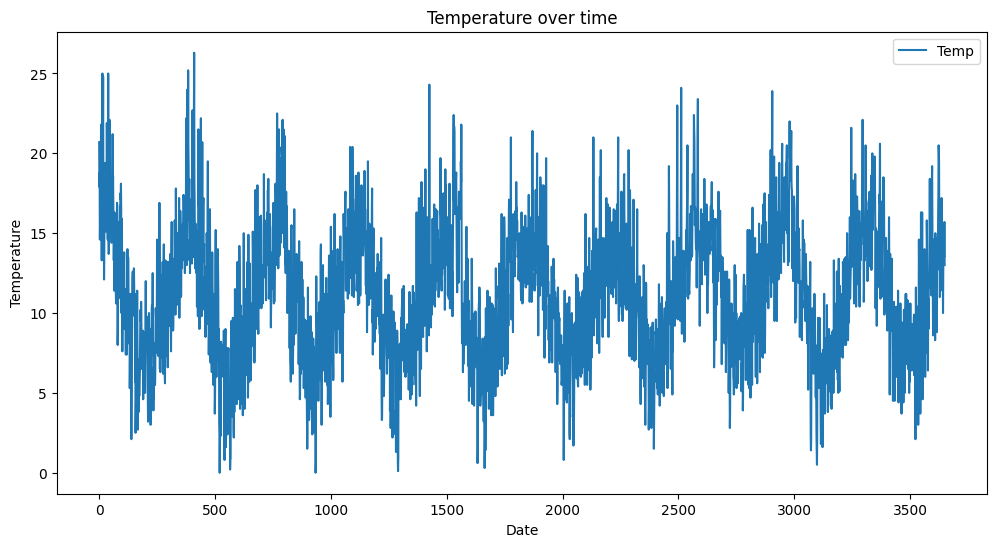

In [5]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(data["Temp"], label="Temp")
plt.title("Temperature over time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

It can be observed in the data visualization that the daily data is quite dense and noisy (due to the amount of data points), making it difficult to observe long-term trends or patterns directly.
Grouping by month might smooth out short-term fluctuations while preserving possible meaningful seasonal and yearly trends.

Before analysing any trend or seasonality, the data will be grouped monthly to smooth the curve

In [6]:
data['year_month'] = data['Date'].dt.to_period('M')
data_monthly = data.groupby('year_month').agg({
    'Temp': ['mean', 'sum', 'min', 'max', 'count', 'std']
}).reset_index()

data_monthly.columns = ['_'.join(col).strip('_') for col in data_monthly.columns.values]
data_monthly['Date'] = data_monthly['year_month'].dt.to_timestamp()

print(data_monthly)

    year_month  Temp_mean  Temp_sum  Temp_min  Temp_max  Temp_count  Temp_std  \
0      1981-01  17.712903     549.1      12.1      25.0          31  3.075358   
1      1981-02  17.678571     495.0      13.7      25.0          28  2.913361   
2      1981-03  13.500000     418.5       8.0      18.6          31  2.849444   
3      1981-04  12.356667     370.7       7.4      18.1          30  3.227328   
4      1981-05   9.490323     294.2       2.1      14.0          31  3.130214   
..         ...        ...       ...       ...       ...         ...       ...   
115    1990-08   7.825806     242.6       2.1      11.6          31  1.743936   
116    1990-09   9.166667     275.0       3.0      16.3          30  3.278807   
117    1990-10  11.345161     351.7       6.0      18.4          31  2.812809   
118    1990-11  12.656667     379.7       8.3      19.2          30  2.612791   
119    1990-12  14.367742     445.4      10.0      20.5          31  2.501651   

          Date  
0   1981-0

With this grouped data set, a new visualization is created to verify the that the smoothing process was successful.

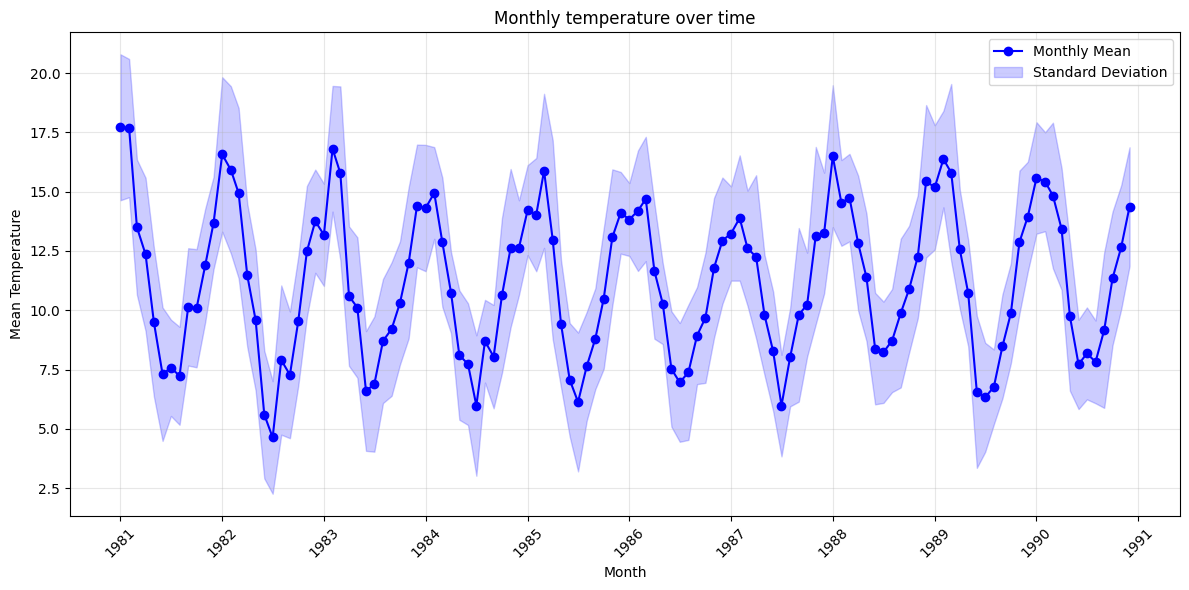

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(data_monthly['Date'], data_monthly['Temp_mean'], marker='o', linestyle='-', color='blue', label='Monthly Mean')

plt.fill_between(data_monthly['Date'], 
                data_monthly['Temp_mean'] - data_monthly['Temp_std'],
                data_monthly['Temp_mean'] + data_monthly['Temp_std'],
                alpha=0.2, color='blue', label='Standard Deviation')

plt.title('Monthly temperature over time')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph allows to perceive a clearer trend in the data, and the deviation doesn't make much of a difference and allows for a clearer analysis of the data, therefore, the exercise will continue with the monthly data.

With this, the 'Date' column will be set as the index (necessary to process time series)

In [8]:
data_monthly = data_monthly.drop(labels=['year_month', 'Temp_sum', 'Temp_min', 'Temp_max', 'Temp_count', 'Temp_std'], axis=1)
data_monthly.set_index('Date', inplace=True)
data_monthly

,Temp_mean
Date,
1981-01-01,17.712903
1981-02-01,17.678571
1981-03-01,13.500000
1981-04-01,12.356667
1981-05-01,9.490323
...,...
1990-08-01,7.825806
1990-09-01,9.166667
1990-10-01,11.345161


In [22]:
data_monthly.describe()

,Temp_mean
count,120.000000
mean,11.200803
std,3.141079
min,4.641935
25%,8.461667
50%,11.117742
75%,13.772581
max,17.712903


### **Decomposition of a time series**
Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.<br>

Additive time series:

Value = Base Level + Trend + Seasonality + Error<br>

#### **Trend**
Represents the general direction of the data in the long term. It can be increasing, decreasing or constant.

#### **Seasonality**
Shows the repetitive and predictable fluctuations within the time series. These fluctuations usually occur in a specific period.<br>

Captures recurring cyclical patterns in the data. For example, an increase in temperature in certain months of the year (summer). If you see a clear pattern in this graph, you can deduce that demand has a significant seasonal component.

#### **Residual**
They are random fluctuations that cannot be explained by trend or seasonality. They represent the error or variability not explained by the additive model.

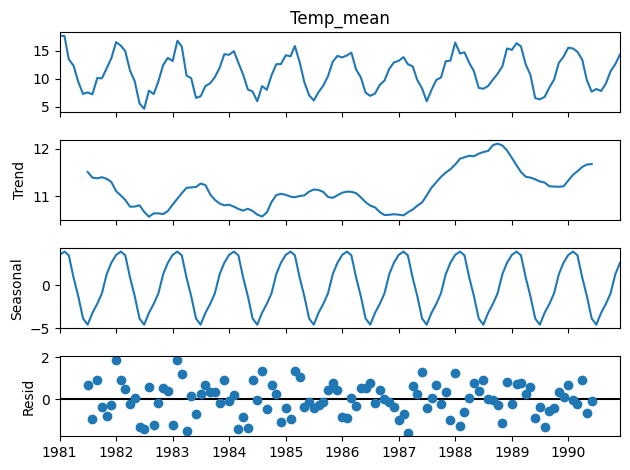

In [9]:
decomposition_additive = seasonal_decompose(data_monthly['Temp_mean'], model='additive', period=12)
decomposition_additive.plot()
plt.show()

The decomposition plot shows four components:
1. Grouped time series (Temp_mean): Shows clear cyclical patterns with values ranging between about 5-15 degrees.
2. Trend: Shows a gradual variation over the years (1981-1990).
3. Seasonal: Shows a consistent repeating pattern.
4. Residual: Random fluctuations remaining after removing trend and seasonality.

All this lead to conclude that the time series is NOT stationary because:
- It has a clear seasonal pattern (regular up and down cycles in the third plot from the top), consistent oscillation, and the pattern repeats itself approximately once a year which agrees with the temperature trends observed in countries where the seasons of the year are very marked (spring, summer, fall, winter). 
- It shows a changing trend over time.
- The mean is not constant across the period.

Also, we can conclude that there is a trend component. The trend plot (second from the top) shows:
- Values around 11 degrees in the early 1980s.
- A dip in the mid-1980s.
- An increase to around 12 degrees in 1989.
- A slight decrease afterward.

#### Split data into train and test data

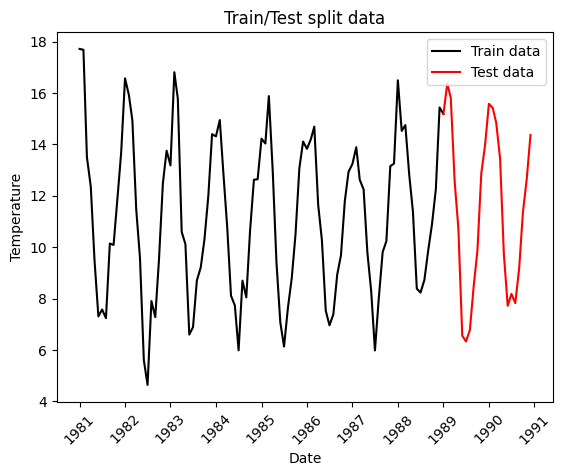

In [10]:
train_size = int(len(data_monthly) * 0.8)

train_data, test_data = data_monthly.iloc[:train_size+1], data_monthly.iloc[train_size:]

plt.plot(train_data, color = "black", label="Train data")
plt.plot(test_data, color = "red", label="Test data")
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.title("Train/Test split data")
plt.show()

### **Holt-Winters Model**
The Holt-Winters model, also known as the Exponential Smoothing model, is a popular method for forecasting time series data that exhibits both trend and seasonality.<br>

Is useful for short to medium-term forecasting where the time series data has clear seasonal patterns and a trend.

In [11]:
hw_model = ExponentialSmoothing(train_data["Temp_mean"], trend="add", seasonal="add", seasonal_periods=12)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(test_data))

hw_rmse = root_mean_squared_error(test_data["Temp_mean"], hw_pred)
hw_mse = mean_squared_error(test_data["Temp_mean"], hw_pred)
hw_mae = mean_absolute_error(test_data["Temp_mean"], hw_pred)
hw_mape = mean_absolute_percentage_error(test_data["Temp_mean"], hw_pred)

hw_metrics = {
    "RMSE": hw_rmse,
    "MSE": hw_mse,
    "MAE": hw_mae,
    "MAPE": hw_mape
}

hw_metrics_df = pd.DataFrame([hw_metrics])
print('Holt-Winters metrics:')
print(hw_metrics_df)


Holt-Winters metrics:
      RMSE       MSE       MAE      MAPE
0  1.97083  3.884172  1.754914  0.169318


c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### **ARIMA Model**
ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, its own past errors (lags), and the errors of previous periods.

ARIMA is suitable for non-seasonal data or when the seasonal component has been removed.

In this case, as the time series has a seasonal component, ARIMA model will not be suitable

In [12]:
arima_model = ARIMA(train_data["Temp_mean"], order=(1, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_data))

arima_rmse = root_mean_squared_error(test_data["Temp_mean"], arima_pred)
arima_mse = mean_squared_error(test_data["Temp_mean"], arima_pred)
arima_mae = mean_absolute_error(test_data["Temp_mean"], arima_pred)
arima_mape = mean_absolute_percentage_error(test_data["Temp_mean"], arima_pred)

arima_metrics = {
    "RMSE": arima_rmse,
    "MSE": arima_mse,
    "MAE": arima_mae,
    "MAPE": arima_mape
}

arima_metrics_df = pd.DataFrame([arima_metrics])
print('ARIMA metrics:')
print(arima_metrics_df)

ARIMA metrics:
       RMSE        MSE       MAE      MAPE
0  4.835612  23.383139  3.825385  0.452256


c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### **SARIMAX Model**
SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. It extends the ARIMA model to support seasonal effects and the inclusion of external variables.

Is ideal for time series data with both trend and seasonality, especially when there are additional external variables that influence the series. It is useful for making more accurate forecasts by incorporating these external factors.

In [13]:
sarimax_model = SARIMAX(train_data["Temp_mean"], order=(1, 0, 1), seasonal_order=(1, 0, 0, 12))
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start=len(train_data), end=(len(train_data) + len(test_data) - 1), typ="levels")

sarimax_rmse = root_mean_squared_error(test_data["Temp_mean"], sarimax_pred)
sarimax_mse = mean_squared_error(test_data["Temp_mean"], sarimax_pred)
sarimax_mae = mean_absolute_error(test_data["Temp_mean"], sarimax_pred)
sarimax_mape = mean_absolute_percentage_error(test_data["Temp_mean"], sarimax_pred)

sarimax_metrics = {
    "RMSE": sarimax_rmse,
    "MSE": sarimax_mse,
    "MAE": sarimax_mae,
    "MAPE": sarimax_mape
}

sarimax_metrics_df = pd.DataFrame([sarimax_metrics])
print('SARIMAX metrics:')
print(sarimax_metrics_df)

c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX metrics:
       RMSE       MSE       MAE      MAPE
0  1.828231  3.342427  1.647658  0.164622


c:\dev\prueba-tecnica-ds-argos\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


### **Result comparison**

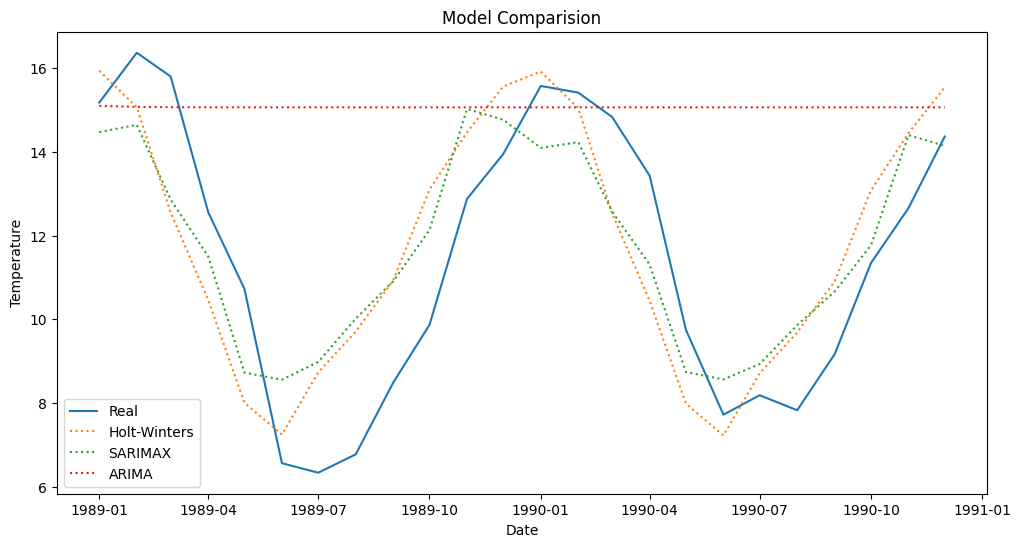

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Temp_mean'], label='Real')
plt.plot(test_data.index, hw_pred, label='Holt-Winters', linestyle="dotted")
plt.plot(test_data.index, sarimax_pred, label='SARIMAX', linestyle="dotted")
plt.plot(test_data.index, arima_pred, label='ARIMA', linestyle="dotted")
plt.title('Model Comparision')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Visually validating the model selection based on how well predicted values align with actual observations, it is safe to conclude that both Holt-Winters and SARIMAX are doing very well capturing the seasonal pattern, but Holt Winters is doing a better job because follows the data closely, specially at the turning points (peaks and valleys). For that reason, I select the Holt-Winters as the most appropriate model to forecast the temperatures according to the provided dataset.

#### **Table of metrics**

In [15]:
metrics = pd.DataFrame({
    'Model': ['Holt-Winters', 'ARIMA', 'SARIMAX'],
    'MSE': [hw_mse, arima_mse, sarimax_mse],
    'MAE': [hw_mae, arima_mae, sarimax_mae],
    'RMSE': [hw_rmse, arima_rmse, sarimax_rmse],
    'MAPE': [hw_mape, arima_mape, sarimax_mape],
})
print(metrics)

          Model        MSE       MAE      RMSE      MAPE
0  Holt-Winters   3.884172  1.754914  1.970830  0.169318
1         ARIMA  23.383139  3.825385  4.835612  0.452256
2       SARIMAX   3.342427  1.647658  1.828231  0.164622


### **Forecasting the next 3 months**

Now I will use all models to forecast the next 3 months of temperature

In [16]:
hw_pred_future = hw_fit.forecast(len(test_data) + 2)
hw_pred_future = hw_pred_future[-3:]

print(f'Holt-Winters forecasting for the next 3 months:\n{hw_pred_future}')

Holt-Winters forecasting for the next 3 months:
1991-01-01    15.543737
1991-02-01    15.900310
1991-03-01    15.028040
Freq: MS, dtype: float64


In [17]:
arima_pred_future = arima_fit.forecast(len(test_data) + 2)
arima_pred_future = arima_pred_future[-3:]

print(f'ARIMA forecasting for the next 3 months:\n{arima_pred_future}')

ARIMA forecasting for the next 3 months:
1991-01-01    15.066077
1991-02-01    15.066077
1991-03-01    15.066077
Freq: MS, Name: predicted_mean, dtype: float64


In [18]:
sarimax_pred_future = sarimax_fit.predict(start=len(data_monthly), end=len(data_monthly) + 2)

print(f'SARIMAX forecasting for the next 3 months:\n{sarimax_pred_future}')

SARIMAX forecasting for the next 3 months:
1991-01-01    14.147050
1991-02-01    13.515112
1991-03-01    13.623551
Freq: MS, Name: predicted_mean, dtype: float64


#### **Creating a dataframe with the forecasting results**

In [19]:
future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=3, freq="MS")

predictions_df = pd.DataFrame(
    {
        'Holt-Winters': hw_pred_future,
        'ARIMA': arima_pred_future,
        'SARIMAX': sarimax_pred_future
    },
    index=future_dates
)

predictions_df

,Holt-Winters,ARIMA,SARIMAX
1991-01-01,15.543737,15.066077,14.147050
1991-02-01,15.900310,15.066077,13.515112
1991-03-01,15.028040,15.066077,13.623551


In [20]:
df_predictions = data_monthly.copy()
df_predictions = pd.concat([data_monthly, predictions_df])

df_predictions.tail()

,Temp_mean,Holt-Winters,ARIMA,SARIMAX
1990-11-01,12.656667,NaN,NaN,NaN
1990-12-01,14.367742,NaN,NaN,NaN
1991-01-01,NaN,15.543737,15.066077,14.147050
1991-02-01,NaN,15.900310,15.066077,13.515112
1991-03-01,NaN,15.028040,15.066077,13.623551


#### **Visualize final results**

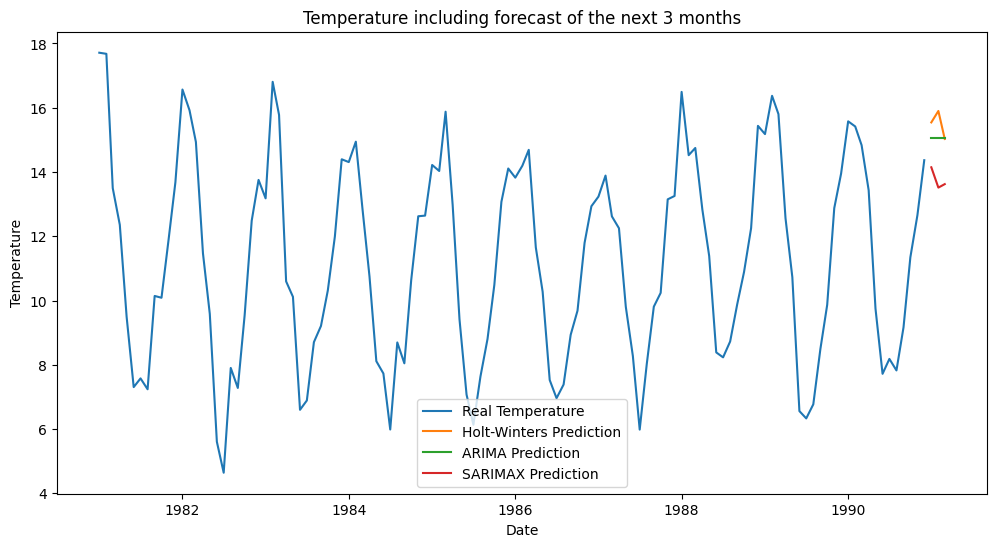

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data_monthly['Temp_mean'], label='Real Temperature')
plt.plot(df_predictions.index, df_predictions['Holt-Winters'], label='Holt-Winters Prediction')
plt.plot(df_predictions.index, df_predictions['ARIMA'], label='ARIMA Prediction')
plt.plot(df_predictions.index, df_predictions['SARIMAX'], label='SARIMAX Prediction')
plt.title('Temperature including forecast of the next 3 months')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()